# English Premier League Top Scorer Prediction Project (2019/20 - 2025/26)

>The primary goal of this notebook is to clean, process, and enrich historical player statistics to create a feature-rich dataset suitable for building a predictive model. This model is designed to forecast the scoring performance `goals` of players in the English Premier League for the upcoming 2025/2026 season.

***2/2***

In [ ]:
try:
  import soccerdata as sd
except:
  !pip install soccerdata
  import soccerdata as sd;


In [ ]:
import soccerdata as sd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [ ]:

SEASONS = ["2025-2026", "2024-2025", "2023-2024", "2022-2023", "2021-2022", "2020-2021", "2019-2020"]
LEAGUE = ["ENG-Premier League"]
understat = sd.Understat(leagues=LEAGUE, seasons=SEASONS)
data = understat.read_player_season_stats()
data = data.reset_index()


[11/16/25 17:53:32] INFO     Saving cached data to /root/soccerdata/data/Understat                   ]8;id=552827;file:///usr/local/lib/python3.12/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=137608;file:///usr/local/lib/python3.12/dist-packages/soccerdata/_common.py#263\263]8;;\

# Data Integration

This stage focuses on **gathering and combining two crucial data sources**:

> *  **Player Statistics:** Detailed, season-by-season player performance metrics for the Premier League are downloaded using the `Understat` scraper, covering seasons from 2019/2020 up to the partial 2025/2026 season.
> *   **Team Contextual Data (`teams_info`):** Supplementary information, including the `previous_season_position` and a binary column `is_in_europe`.

A necessary step of **team name mapping** is performed to ensure consistent naming conventions between the two DataFrames before they are successfully merged `df` using common keys (`team` and `season`).

In [ ]:
path="https://raw.githubusercontent.com/ruus77/Portfolio/refs/heads/main/PL_best_scorer/teams_info.csv"
teams_stats = pd.read_csv(path)
teams_stats.drop('Unnamed: 0', axis=1, inplace=True)
teams_stats[teams_stats.season==2425]


,team,previous_season_position,is_in_europe,season
100,Man City,1,1,2425
101,Arsenal,2,1,2425
102,Liverpool,3,1,2425
103,Aston Villa,4,1,2425
104,Tottenham,5,1,2425
105,Chelsea,6,1,2425
106,Newcastle,7,0,2425
107,Man United,8,0,2425
108,West Ham,9,0,2425
109,Crystal Palace,10,0,2425


In [ ]:
data.columns

Index(['league', 'season', 'team', 'player', 'league_id', 'season_id',
       'team_id', 'player_id', 'position', 'matches', 'minutes', 'goals', 'xg',
       'np_goals', 'np_xg', 'assists', 'xa', 'shots', 'key_passes',
       'yellow_cards', 'red_cards', 'xg_chain', 'xg_buildup'],
      dtype='object')

In [ ]:
players = list(data.player.unique())
len(players)

1440

In [ ]:
df = data.sort_values(by=["season", "team"]).copy()

In [ ]:
df.season.unique()

array(['1920', '2021', '2122', '2223', '2324', '2425', '2526'],
      dtype=object)

In [ ]:
players = df.player.unique()
df.player.shape, len(players)


((3711,), 1440)

In [ ]:
teams_map = {
    "Man City": "Manchester City",
    "Man United": "Manchester United",
    "Liverpool": "Liverpool",
    "Chelsea": "Chelsea",
    "Leicester": "Leicester",
    "West Ham": "West Ham",
    "Tottenham": "Tottenham",
    "Arsenal": "Arsenal",
    "Leeds": "Leeds",
    "Everton": "Everton",
    "Aston Villa": "Aston Villa",
    "Newcastle": "Newcastle United",
    "Wolves": "Wolverhampton Wanderers",
    "Crystal Palace": "Crystal Palace",
    "Southampton": "Southampton",
    "Sunderland" : "Sunderland",
    "Brighton": "Brighton",
    "Burnley": "Burnley",
    "Fulham": "Fulham",
    "Sheffield United": "Sheffield United",
    "Brentford": "Brentford",
    "Watford": "Watford",
    "Norwich": "Norwich",
    "Bournemouth": "Bournemouth",
    "Nott'm Forest": "Nottingham Forest",
    "Luton": "Luton",
    "Ipswich": "Ipswich",
    "West Brom": "West Brom"
}

In [ ]:
teams_stats.team = teams_stats.team.map(teams_map)
teams_stats.tail()

,team,previous_season_position,is_in_europe,season
135,Wolverhampton Wanderers,16,0,2526
136,Tottenham,17,0,2526
137,Leicester,18,0,2526
138,Ipswich,19,0,2526
139,Southampton,20,0,2526


In [ ]:
df.tail()

,league,season,team,player,league_id,season_id,team_id,player_id,position,matches,minutes,goals,xg,np_goals,np_xg,assists,xa,shots,key_passes,yellow_cards,red_cards,xg_chain,xg_buildup
3706,ENG-Premier League,2526,Wolverhampton Wanderers,Santiago Bueno,1,2025,229,10945,D S,8,659,1,0.697321,1,0.697321,0,0.086949,2,3,2,0,1.438977,1.324602
3707,ENG-Premier League,2526,Wolverhampton Wanderers,Sasa Kalajdzic,1,2025,229,8812,S,1,11,0,0.0,0,0.0,0,0.0,0,0,0,0,0.0,0.0
3708,ENG-Premier League,2526,Wolverhampton Wanderers,Tolu Arokodare,1,2025,229,8875,F S,7,195,0,0.407681,0,0.407681,0,0.290688,6,1,0,0,1.100396,0.475031
3709,ENG-Premier League,2526,Wolverhampton Wanderers,Toti,1,2025,229,10293,D S,8,541,0,0.053998,0,0.053998,0,0.082192,2,4,2,1,0.684298,0.602105
3710,ENG-Premier League,2526,Wolverhampton Wanderers,Yerson Mosquera,1,2025,229,9958,D S,4,186,0,0.054043,0,0.054043,0,0.0,2,0,1,0,0.324825,0.290688


In [ ]:
df['season'] = df['season'].astype(int)
teams_stats['season'] = teams_stats['season'].astype(int)

df = df.merge(
    teams_stats,
    on=['team', 'season'],
    how='left'
)
df = df.copy()
df = df.sort_values(by=["season_id", "team"])
df.head()

,league,season,team,player,league_id,season_id,team_id,player_id,position,matches,minutes,goals,xg,np_goals,np_xg,assists,xa,shots,key_passes,yellow_cards,red_cards,xg_chain,xg_buildup,previous_season_position,is_in_europe
0,ENG-Premier League,1920,Arsenal,Ainsley Maitland-Niles,1,2019,83,1750,D S,20,1372,0,0.508408,0,0.508408,2,1.646097,4,11,4,1,5.156502,3.567148,5.0,1.0
1,ENG-Premier League,1920,Arsenal,Alexandre Lacazette,1,2019,83,3277,F S,30,1890,10,8.664644,10,8.664644,4,3.342293,52,24,8,0,12.06131,2.505634,5.0,1.0
2,ENG-Premier League,1920,Arsenal,Bernd Leno,1,2019,83,181,GK,30,2649,0,0.0,0,0.0,0,0.0,0,0,2,0,4.038204,4.038204,5.0,1.0
3,ENG-Premier League,1920,Arsenal,Bukayo Saka,1,2019,83,7322,D F M S,26,1769,1,1.142438,1,1.142438,5,3.680353,13,21,6,0,7.812512,5.022922,5.0,1.0
4,ENG-Premier League,1920,Arsenal,Calum Chambers,1,2019,83,508,D S,14,1102,1,0.63295,1,0.63295,1,2.241444,12,7,5,0,4.406148,3.21047,5.0,1.0


In [ ]:
df.previous_season_position.fillna(21, inplace=True)
df.is_in_europe.fillna(0, inplace=True)


# Feature Engineering and Lags Generation

This part is focused on creating highly predictive variables:

>* **Per-90 Metrics:** Performance statistics like **goals per 90 minutes (`g90`)**, **assists per 90 minutes (`a90`)**, and the difference between goals and expected goals (**`xg_perf`**) are calculated. These metrics normalize output based on playing time, offering a truer measure of player efficiency.
>* **Lagged Features:** A function is used to create **lagged features**, incorporating key statistics from the previous one or two seasons. This temporal information captures a player's historical form and stability, which is crucial for prediction.
>* **Imputation Strategy:** A robust imputation method is applied for players missing historical data (e.g., those who played fewer minutes or were new to the league). Missing lagged values are filled using the **25th percentile** of the respective statistical group (grouped by player position). This conservative approach avoids overestimating the prior potential of players with limited historical data.
>* **Feature Selection:** The raw metrics used in the calculations are dropped from the final DataFrame to prevent multicollinearity and simplify the model input.

In [ ]:
df.player = df.player.apply(lambda x: x.lower())

In [ ]:
df = df.sort_values(by=["player", "season"])

In [ ]:
df['safe_matches'] = df["matches"].replace(0, np.nan)
df['safe_shots'] = df["shots"].replace(0, np.nan)
df['fmp'] = df["minutes"] / 90
df['safe_fmp'] = df['fmp'].replace(0, np.nan)

df['mpm'] = (df["minutes"] / df["safe_matches"]).fillna(0)
df['xg_perf'] = (df['goals'] - df['xg'])
df['npxg_perf'] = (df['np_goals'] - df['np_xg'])
df['xg_per_shot'] = (df['xg'] / df['safe_shots']).fillna(0)
df['penalty_taker'] = np.where(df.xg == df.np_xg, 0, 1)
df['g90'] = (df.goals / df["safe_fmp"]).fillna(0)
df['a90'] = (df.assists / df["safe_fmp"]).fillna(0)
df['ga90'] = df['g90'] + df['a90']
df['xg90'] = (df.xg / df["safe_fmp"]).fillna(0)
df['xa90'] = (df.xa / df["safe_fmp"]).fillna(0)

avg_per_position = df.groupby("position")["xg_per_shot"].mean()




In [ ]:
cols_to_lag = ["mpm", "fmp", "xg_perf", "npxg_perf", "xg_per_shot", "penalty_taker", "g90", "a90", "ga90", "xg90", "xa90", "goals"]

In [ ]:
for col in cols_to_lag:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)

In [ ]:
def lagged_cols(data:pd.DataFrame, cols_to_lag: list, num_of_lags=2):
  data = data.copy()
  train_mask = ~data['season'].isin([2425, 2526])
  avg_maps = {col: data[train_mask].groupby("position")[col].quantile(.25) for col in cols_to_lag}

  for lag in range(1, num_of_lags + 1):
        for col in cols_to_lag:
          new_col_name = f"lagged_{col}_{lag}"
          lagged_col = data.groupby("player")[col].shift(lag)
          data[new_col_name] = lagged_col.fillna(data["position"].map(avg_maps[col])).fillna(0)
  return data

In [ ]:
lagged_frame = lagged_cols(df, cols_to_lag=cols_to_lag)
lagged_frame.head()

,league,season,team,player,league_id,season_id,team_id,player_id,position,matches,minutes,goals,xg,np_goals,np_xg,assists,xa,shots,key_passes,yellow_cards,red_cards,xg_chain,xg_buildup,previous_season_position,is_in_europe,safe_matches,safe_shots,fmp,safe_fmp,mpm,xg_perf,npxg_perf,xg_per_shot,penalty_taker,g90,a90,ga90,xg90,xa90,lagged_mpm_1,lagged_fmp_1,lagged_xg_perf_1,lagged_npxg_perf_1,lagged_xg_per_shot_1,lagged_penalty_taker_1,lagged_g90_1,lagged_a90_1,lagged_ga90_1,lagged_xg90_1,lagged_xa90_1,lagged_goals_1,lagged_mpm_2,lagged_fmp_2,lagged_xg_perf_2,lagged_npxg_perf_2,lagged_xg_per_shot_2,lagged_penalty_taker_2,lagged_g90_2,lagged_a90_2,lagged_ga90_2,lagged_xg90_2,lagged_xa90_2,lagged_goals_2
84,ENG-Premier League,1920,Brighton,aaron connolly,1,2019,220,7991,F S,24,1279,3.0,4.553528,3,4.553528,1,0.562017,36,6,0,0,4.356781,0.354199,17.0,0.0,24,36,14.211111,14.211111,53.291667,-1.553528,-1.553528,0.126487,0.0,0.211102,0.070367,0.281470,0.320420,0.039548,31.547101,5.322222,-1.946718,-1.990343,0.125597,0.0,0.149728,0.000000,0.256184,0.302738,0.065931,1.0,31.547101,5.322222,-1.946718,-1.990343,0.125597,0.0,0.149728,0.000000,0.256184,0.302738,0.065931,1.0
568,ENG-Premier League,2021,Brighton,aaron connolly,1,2020,220,7991,F M S,17,799,2.0,4.464138,2,4.464138,1,0.160784,23,6,0,0,4.783492,0.191225,15.0,0.0,17,23,8.877778,8.877778,47.000000,-2.464138,-2.464138,0.194093,0.0,0.225282,0.112641,0.337922,0.502844,0.018111,53.291667,14.211111,-1.553528,-1.553528,0.126487,0.0,0.211102,0.070367,0.281470,0.320420,0.039548,3.0,49.213750,12.600000,-1.376220,-1.381881,0.089116,0.0,0.132491,0.056393,0.259811,0.161672,0.100226,2.0
1125,ENG-Premier League,2122,Brighton,aaron connolly,1,2021,220,7991,F S,4,152,0.0,0.599489,0,0.599489,0,0.380411,2,1,0,0,1.007935,0.028035,16.0,0.0,4,2,1.688889,1.688889,38.000000,-0.599489,-0.599489,0.299744,0.0,0.000000,0.000000,0.000000,0.354961,0.225243,47.000000,8.877778,-2.464138,-2.464138,0.194093,0.0,0.225282,0.112641,0.337922,0.502844,0.018111,2.0,53.291667,14.211111,-1.553528,-1.553528,0.126487,0.0,0.211102,0.070367,0.281470,0.320420,0.039548,3.0
466,ENG-Premier League,1920,West Ham,aaron cresswell,1,2019,81,534,D,31,2739,3.0,1.032539,3,1.032539,0,3.006656,18,26,7,0,6.834942,4.891464,10.0,0.0,31,18,30.433333,30.433333,88.354839,1.967461,1.967461,0.057363,0.0,0.098576,0.000000,0.098576,0.033928,0.098795,86.580357,12.991667,-0.602176,-0.602176,0.045165,0.0,0.000000,0.000000,0.000000,0.015674,0.006024,0.0,86.580357,12.991667,-0.602176,-0.602176,0.045165,0.0,0.000000,0.000000,0.000000,0.015674,0.006024,0.0
989,ENG-Premier League,2021,West Ham,aaron cresswell,1,2020,81,534,D,36,3176,0.0,0.883464,0,0.883464,8,7.39094,19,58,3,0,10.620283,8.392439,16.0,0.0,36,19,35.288889,35.288889,88.222222,-0.883464,-0.883464,0.046498,0.0,0.000000,0.226700,0.226700,0.025035,0.209441,88.354839,30.433333,1.967461,1.967461,0.057363,0.0,0.098576,0.000000,0.098576,0.033928,0.098795,3.0,86.580357,12.991667,-0.602176,-0.602176,0.045165,0.0,0.000000,0.000000,0.000000,0.015674,0.006024,0.0


In [ ]:
df = lagged_frame.copy()

In [ ]:
cols_to_drop = [
    'safe_matches', 'safe_shots', 'fmp', 'safe_fmp',
    'mpm', 'xg_perf', 'npxg_perf', 'xg_per_shot', 'penalty_taker',
    'g90', 'a90', 'ga90', 'xg90', 'xa90'
]
df = df.drop(columns=cols_to_drop)

# Position Mapping and Encoding

To effectively utilize player position, which strongly correlates with scoring output, the data is processed:

>* **Position Simplification:** Complex, detailed positional roles are mapped to a simplified numerical scale (`main_pos`) representing general roles.
>* **One-Hot Encoding:** The simplified positional categories are converted into several **binary (dummy) variables**.
This ensures the categorical data is in a numerical format that predictive algorithms can correctly process.

In [ ]:
df.sort_values(by=["season", "team"])
list(df.position.unique())


['F S',
 'F M S',
 'D',
 'D S',
 'M S',
 'GK',
 'S',
 'D M S',
 'D M',
 'M',
 'D F M S',
 'GK S',
 'F M',
 'F',
 'D F M',
 'D F S']

In [ ]:
df.isna().sum().sum()

np.int64(0)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
position_map = {
    'GK': 0,
    'GK S': 0,

    'D S': 1,
    'D': 1,

    'M': 2,
    'D M S': 2,
    'M S': 2,
    'D M': 2,

    'F M S': 3,
    'F S': 3,
    'D F M S': 3,
    'F M': 3,
    'F': 3,
    'D F S': 3,
    'D F M': 3,

    'S': 4
}

In [ ]:
df["main_pos"] = df.position.map(position_map)

In [ ]:
df.select_dtypes(["object", "category"])

,league,team,player
84,ENG-Premier League,Brighton,aaron connolly
568,ENG-Premier League,Brighton,aaron connolly
1125,ENG-Premier League,Brighton,aaron connolly
466,ENG-Premier League,West Ham,aaron cresswell
989,ENG-Premier League,West Ham,aaron cresswell
...,...,...,...
1627,ENG-Premier League,Aston Villa,álex moreno
2185,ENG-Premier League,Aston Villa,álex moreno
3138,ENG-Premier League,Nottingham Forest,álex moreno
1124,ENG-Premier League,Brentford,álvaro fernández


# Key Data Visualizations

>* **Goals Distribution by Position:** Shows that goal-scoring propensity is **heavily concentrated** in offensive roles.
>* **Top Scorers:** Highlights the top 10 goal scorers of the `2425` season, with colored markers for the podium finishers.
>* **Goals-to-xG Ratio:** Identifies players with the highest **clinical finishing ability**, comparing actual goals to expected goals (xG).
>* **European Load on Minutes:** Compares the distribution of league minutes (`minutes`) between players involved in European competitions vs. those who were not, testing the impact of **fixture congestion**.

In [ ]:
df[(df["season_id"] == 2024) & (df["goals"] > 7) & (df["league"]=="ENG-Premier League")][["goals", "assists", "player"]].sort_values(by=["goals", "assists"], ascending=False).head()

,goals,assists,player
3026,29.0,18,mohamed salah
3092,23.0,6,alexander isak
3037,22.0,3,erling haaland
2783,20.0,7,bryan mbeumo
3118,20.0,3,chris wood


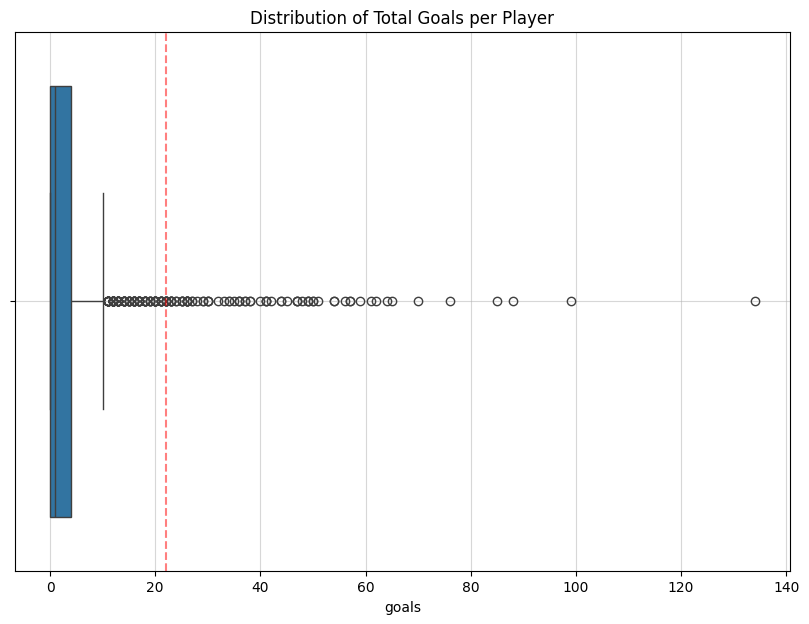

In [ ]:
plt.figure(figsize=(10, 7))
ax = sns.boxplot(df.groupby("player")["goals"].sum(), orient="h")
ax.axvline(df.groupby("player")["goals"].sum().quantile(.95), color="red", linestyle="--", alpha=0.5, title="");
plt.grid(True, alpha=0.5)
plt.title("Distribution of Total Goals per Player");

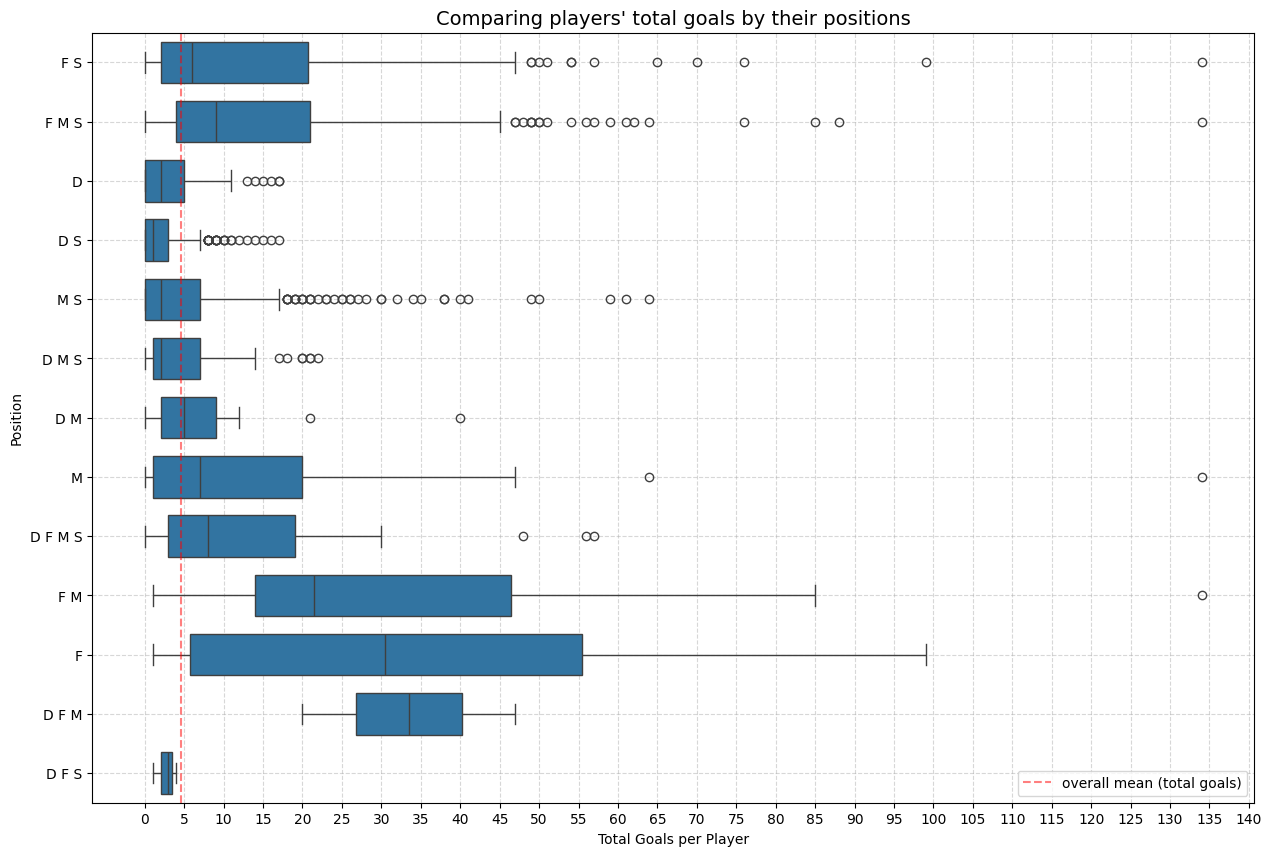

In [ ]:
total_goals_df = df.groupby('player', as_index=False)['goals'].sum()
player_positions = df[['player', 'position']].drop_duplicates()

plt.figure(figsize=(15, 10))

ax = sns.boxplot(
    data=pd.merge(total_goals_df, player_positions, on='player')[
        lambda x: ~x.position.isin(["GK", "S", "GK S"])
    ],
    y="position",
    x="goals",
    width=0.7,
)

ax.axvline(
    x=total_goals_df['goals'].mean(),
    color="red",
    alpha=0.5,
    linestyle="--",
    label="overall mean (total goals)"
)

plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(np.arange(0, 141, 5))
plt.title("Comparing players' total goals by their positions", fontsize=14)
plt.xlabel("Total Goals per Player")
plt.ylabel("Position")
plt.legend()
plt.show()

In [ ]:
total_goals = df.groupby("player").goals.sum()
total_goals[total_goals >= total_goals.quantile(0.95)].sort_values(ascending=False)

,goals
player,
mohamed salah,134.0
erling haaland,99.0
harry kane,88.0
son heung-min,85.0
ollie watkins,76.0
...,...
abdoulaye doucouré,23.0
hee-chan hwang,23.0
miguel almirón,23.0


In [ ]:
data_to_plot = df[
    (df["season_id"] == 2024) &
    (df["goals"] > 7) &
    (df["league"]=="ENG-Premier League")
][["goals", "assists", "player"]].sort_values(by=["goals", "assists"], ascending=False).copy()

color_map = {
    'Top 1': '#DC143C',
    'Top 2': '#5C5C5C',
    'Top 3': '#6caddf',
    'Rest': '#cccccc'
}
conditions = [
    data_to_plot.index == data_to_plot.index[0],
    data_to_plot.index == data_to_plot.index[1],
    data_to_plot.index == data_to_plot.index[2],
]
choices = ['Top 1', 'Top 2', 'Top 3']

data_to_plot['color_group'] = np.select(conditions, choices, default='Rest')

Text(0.5, 1.0, 'Top 10 scorers in season 2425')

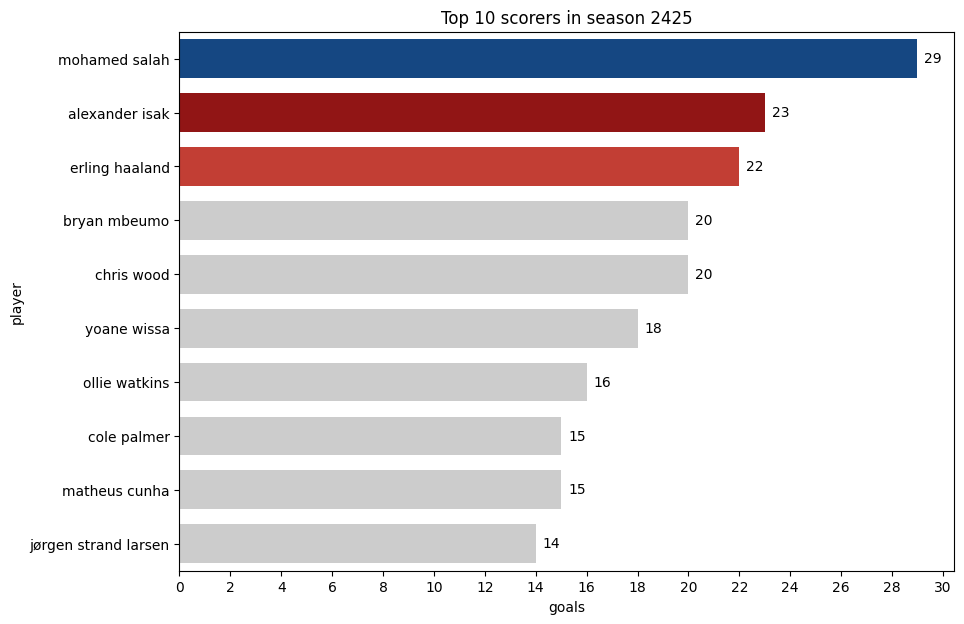

In [ ]:
plt.figure(figsize=(10, 7))
ax = sns.barplot(
    gap=0.1,
    y="player",
    x="goals",
    orient="h",
    hue="color_group",
    palette=color_map,
    data=data_to_plot.iloc[0:10],
    dodge=False,
    legend=False
)

max_goals = data_to_plot['goals'].max()
ax.set_xticks(np.arange(0, max_goals + 2, 2))

for container in ax.containers:
    ax.bar_label(container, padding=5, fmt='%.0f')

labels = ax.get_yticklabels()
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels, ha='right')

plt.title("Top 10 scorers in season 2425")


In [ ]:
best_xg_to_goals = df[(df.goals>5) &
  (df.season==2425) &
  (df.xg>0) &
  (df.main_pos.isin([2, 3]))].groupby("player")[["goals", "xg"]].sum().assign(xg_to_goals=lambda d: d["goals"] / d["xg"]).sort_values(by="xg_to_goals", ascending=False).reset_index()

color_map = {
'Top 1': '#034694',
    'Top 2': '#A60000',
    'Top 3': '#DA291C',
    'Rest': '#cccccc'
}

conditions = [
    best_xg_to_goals.index == 0,
    best_xg_to_goals.index == 1,
    best_xg_to_goals.index == 2,
]
choices = ['Top 1', 'Top 2', 'Top 3']

best_xg_to_goals['color_group'] = np.select(conditions, choices, default='Rest')

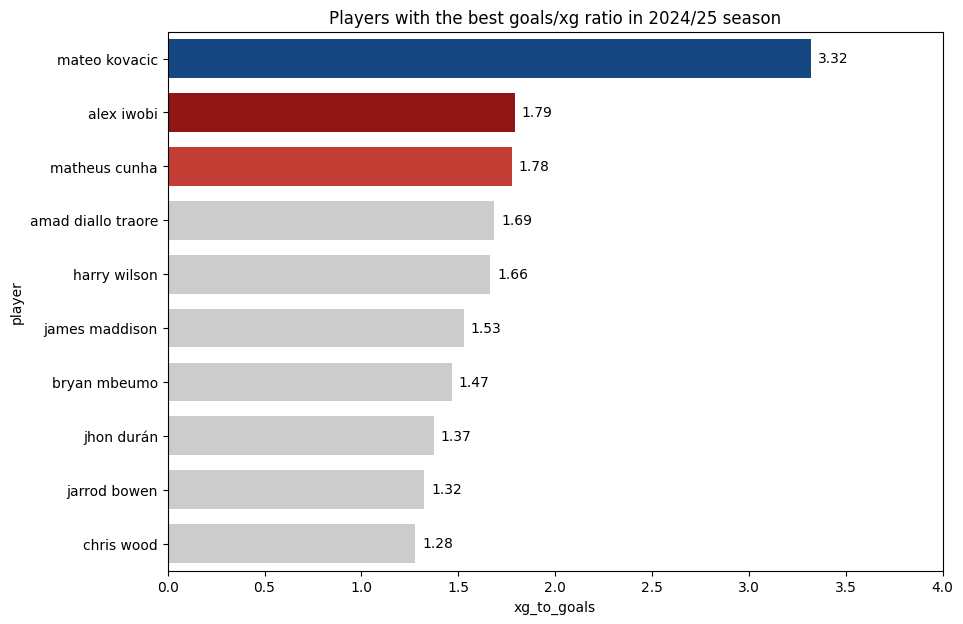

In [ ]:
plt.figure(figsize=(10, 7))
ax = sns.barplot(data=best_xg_to_goals.head(10),
            y="player",
            orient="y",
            gap=0.1,
            hue="color_group",
            palette=color_map,
            x="xg_to_goals")
plt.title("Players with the best goals/xg ratio in 2024/25 season");

ax.set_xticks(np.arange(0, best_xg_to_goals.xg_to_goals.max() + 1, 0.5));
ax.get_legend().remove()

for container in ax.containers:
    ax.bar_label(container, padding=5, fmt='%.2f')




In [ ]:
best_xg_to_goals.tail()

,player,goals,xg,xg_to_goals,color_group
59,ismaila sarr,8.0,12.308559,0.649954,Rest
60,dango ouattara,7.0,10.93368,0.640224,Rest
61,alejandro garnacho,6.0,9.439806,0.635606,Rest
62,noni madueke,7.0,11.862219,0.590109,Rest
63,diogo jota,6.0,10.206197,0.587878,Rest


In [ ]:
df.columns

Index(['league', 'season', 'team', 'player', 'league_id', 'season_id',
       'team_id', 'player_id', 'position', 'matches', 'minutes', 'goals', 'xg',
       'np_goals', 'np_xg', 'assists', 'xa', 'shots', 'key_passes',
       'yellow_cards', 'red_cards', 'xg_chain', 'xg_buildup',
       'previous_season_position', 'is_in_europe', 'lagged_mpm_1',
       'lagged_fmp_1', 'lagged_xg_perf_1', 'lagged_npxg_perf_1',
       'lagged_xg_per_shot_1', 'lagged_penalty_taker_1', 'lagged_g90_1',
       'lagged_a90_1', 'lagged_ga90_1', 'lagged_xg90_1', 'lagged_xa90_1',
       'lagged_goals_1', 'lagged_mpm_2', 'lagged_fmp_2', 'lagged_xg_perf_2',
       'lagged_npxg_perf_2', 'lagged_xg_per_shot_2', 'lagged_penalty_taker_2',
       'lagged_g90_2', 'lagged_a90_2', 'lagged_ga90_2', 'lagged_xg90_2',
       'lagged_xa90_2', 'lagged_goals_2', 'main_pos', 'position_1',
       'position_2', 'position_3', 'position_4'],
      dtype='object')

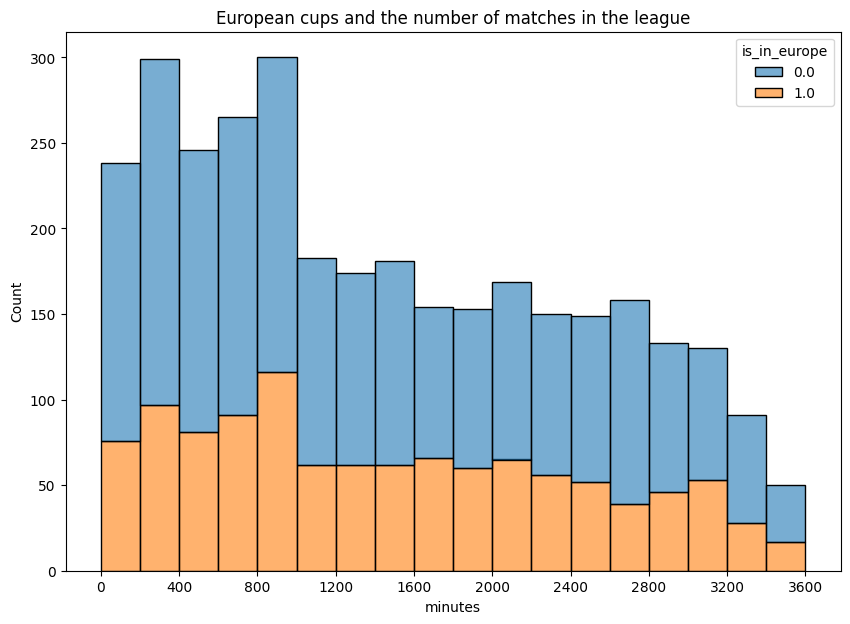

In [ ]:
plt.figure(figsize=(10, 7))

sns.histplot(
    data=df[df.minutes>90],
    x="minutes",
    hue="is_in_europe",
    alpha=0.6,
    bins=np.arange(0, 3800, 200),
    legend=True,
    multiple="stack")

plt.title("European cups and the number of matches in the league")
plt.xlabel("minutes")
plt.xticks(np.arange(0, 3800, 400));

In [ ]:
positions = pd.get_dummies(df.main_pos, drop_first=True, prefix="position").astype(int)
df = df.join(positions, how="right")

In [ ]:
df = df.sort_values(by=["player", "season"])

df.to_csv("PL_1920_2526.csv")